## Testing NMT models and using NMT on NewsQA Dataset

Source: https://pytorch.org/hub/pytorch_fairseq_translation/

In [40]:
import torch
from data import *
from typing import *
from argparse import Namespace
import time
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
torch.hub.list('pytorch/fairseq')

Using cache found in /Users/alexstoken/.cache/torch/hub/pytorch_fairseq_master


['bart.base',
 'bart.large',
 'bart.large.cnn',
 'bart.large.mnli',
 'bart.large.xsum',
 'bpe',
 'camembert',
 'camembert-base',
 'camembert-base-ccnet',
 'camembert-base-ccnet-4gb',
 'camembert-base-oscar-4gb',
 'camembert-base-wikipedia-4gb',
 'camembert-large',
 'camembert.v0',
 'conv.stories',
 'conv.stories.pretrained',
 'conv.wmt14.en-de',
 'conv.wmt14.en-fr',
 'conv.wmt17.en-de',
 'data.stories',
 'dynamicconv.glu.wmt14.en-fr',
 'dynamicconv.glu.wmt16.en-de',
 'dynamicconv.glu.wmt17.en-de',
 'dynamicconv.glu.wmt17.zh-en',
 'dynamicconv.no_glu.iwslt14.de-en',
 'dynamicconv.no_glu.wmt16.en-de',
 'gottbert-base',
 'lightconv.glu.wmt14.en-fr',
 'lightconv.glu.wmt16.en-de',
 'lightconv.glu.wmt17.en-de',
 'lightconv.glu.wmt17.zh-en',
 'lightconv.no_glu.iwslt14.de-en',
 'lightconv.no_glu.wmt16.en-de',
 'roberta.base',
 'roberta.large',
 'roberta.large.mnli',
 'roberta.large.wsc',
 'tokenizer',
 'transformer.flores101.mm100.175M',
 'transformer.flores101.mm100.615M',
 'transformer.wmt14

In [3]:
# Round-trip translations between English and German:
en2de = torch.hub.load('pytorch/fairseq', 'transformer.wmt19.en-de.single_model', tokenizer='moses', bpe='fastbpe')
de2en = torch.hub.load('pytorch/fairseq', 'transformer.wmt19.de-en.single_model', tokenizer='moses', bpe='fastbpe')

Using cache found in /Users/alexstoken/.cache/torch/hub/pytorch_fairseq_master
Using cache found in /Users/alexstoken/.cache/torch/hub/pytorch_fairseq_master


In [4]:
def backtranslate(sent, forward, backward):
    """
    Parameters
    ----------
    sent (str): sentence to be backtranslated
    forward (torch.nn): model to translate from langauge 1 to language 2
    backward (torch.nn): model to translate from langauge 2 to langauge 1
    
    Return:
    backtrans_sent: backtranslated sentence
    """
    forward = forward.eval()
    backward = backward.eval()
    return backward.translate(forward.translate(sent))

In [5]:
# Set up datasets
dataset_args = {'num_answers':1,
               'unique_samples':1,
               'lowercase_passage': True,
                'lowercase_question': True,
                'max_context_length':1024,
                'max_question_length':128,
                'batch_size': 12,
                'train_path':'datasets/newsqa_train.jsonl.gz'
               }
args = Namespace(**dataset_args)
train_dataset = QADataset(args, args.train_path)

Max number of answers in this dataset: 1


In [6]:
idx = 20

In [7]:
sample = train_dataset.samples[idx]

In [8]:
sample[1][sample[3]:sample[4]] # answer (sample paragraph from (start, end))

['sgt', '.', 'michael', 'strank']

In [9]:
' '.join(sample[1])

'washington ( cnn ) -- one of the marines shown in a famous world war ii photograph raising the u.s. flag on iwo jima was posthumously awarded a certificate of u.s. citizenship on tuesday . the marine corps war memorial in virginia depicts strank and five others raising a flag on iwo jima . sgt . michael strank , who was born in czechoslovakia and came to the united states when he was 3 , derived u.s. citizenship when his father was naturalized in 1935 . however , u.s. citizenship and immigration services recently discovered that strank never was given citizenship papers . at a ceremony tuesday at the marine corps memorial -- which depicts the flag - raising -- in arlington , virginia , a certificate of citizenship was presented to strank \'s younger sister , mary pero . strank and five other men became national icons when an associated press photographer captured the image of them planting an american flag on top of mount suribachi on february 23 , 1945 . strank was killed in action o

In [10]:
%%time
backtranslate(' '.join(sample[1]), en2de, de2en)

CPU times: user 40.2 s, sys: 4.68 s, total: 44.9 s
Wall time: 43.4 s


"washington (cnn) -- one of the marines featured in a famous World War II photograph raised the U.S. flag on iwo jima. sgt. michael strank, who was born in Czechoslovakia and came to the United States at the age of 3, was granted U.S. citizenship when his father was naturalized in 1935. nevertheless, citizenship and immigration authorities recently discovered that strank never received citizenship papers. strank and five other men became national icons when an associated press photographer presented a citizenship certificate to Strank's younger sister, mary pero, at the Marine Corps Memorial in Arlington, Virginia on Tuesday. strank and five other men became national icons"

In [15]:
answer_len = []
question_len = []
passage_len = []
for s in train_dataset.samples:
    answer_len.append(s[4]-s[3])
    question_len.append(len(s[2]))
    passage_len.append(len(s[1]))

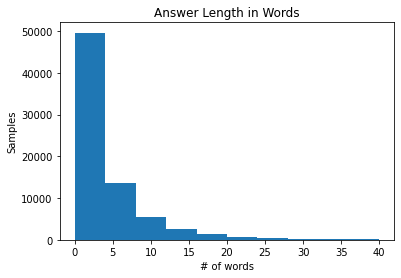

In [16]:
plt.hist(answer_len, range=(0,40))
plt.xlabel('# of words')
plt.ylabel('Samples')
plt.title('Answer Length in Words');

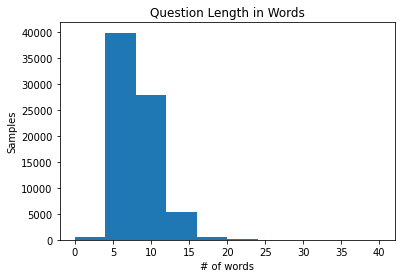

In [21]:
plt.hist(question_len, range=(0,40))
plt.xlabel('# of words')
plt.ylabel('Samples')
plt.title('Question Length in Words');

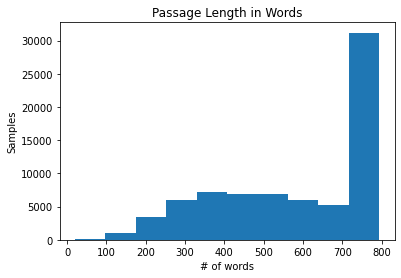

In [22]:
plt.hist(passage_len)
plt.xlabel('# of words')
plt.ylabel('Samples')
plt.title('Passage Length in Words');

In [24]:
s[2]

['how', 'many', 'yeras', 'old', 'was', 'christopher', 'rodriguez', '?']

## Paraphrase all of the questions

In [28]:
new_samples: List[Tuple] = []
for jdx, s in enumerate(train_dataset.samples[:100]):
    new_sample = list(s)
    q = ' '.join(s[2])
    backtrans = backtranslate(q, en2de, de2en)
    
    if jdx % 10 == 0:
        print(q,backtrans)
    
    new_sample[2] = backtrans.split()
    
    new_samples.append(new_sample)

what was the amount of children murdered ? What was the number of murdered children?
where was michael strank born ? where was michael drink born?
who was among the six who raised the flag in iwo jima ? Who was among the six who hoisted the flag in Iwo Jima?
what happened in chad what happened in chad
what did gerrard admit doing ? What did Gerrard admit?
who is calling for the official 's resignation ? Who is calling for the civil servant to resign?
who says " why he is a saint : the true story of john paul ii " ? who says "why he is a saint: the true story of john paul ii"?
how many flights were affects ? How many flights were affected?
what do his tweets talk about ? What are his tweets talking about?
census bureaus are hiring people from where ? Where do census offices hire people?


In [ ]:
backtranslate(' '.join(sample[1]), en2de, de2en)

In [42]:
def backtranslate_questions(train_dataset,  batch_size, forward_translate, backward_translate, n=None):
    start = time.time()
    new_samples: List[Tuple] = []
    if n is None:
        n = len(train_dataset.samples)
    for batch_start in range(0, len(train_dataset.samples[:n]), batch_size):
        
    
        
        # build a batch as a list
        batch = []
        batched_questions = []
        for s in train_dataset.samples[batch_start:batch_start + batch_size]:
            batched_questions.append(' '.join(s[2]))
            batch.append(list(s))

        batched_backtrans_qs = backtranslate(batched_questions, forward_translate, backward_translate)


        for backtrans_q, new_sample in zip(batched_backtrans_qs, batch):
            new_sample[2] = backtrans_q.split()
            new_sample = tuple(new_sample)
        new_samples += batch
    #print(batch_start, time.time()-start)
    return new_samples

In [31]:
train_dataset.samples[10:10+3]

list

In [43]:
new_samples = backtranslate_questions(train_dataset, batch_size=100, forward_translate=en2de, backward_translate=de2en, n=200)

100 137.18489980697632


In [51]:
new_questions = 0
for i in range(len(new_samples)):
    if new_samples[i][2] != train_dataset.samples[i][2]:
        new_questions +=1
new_questions

195

In [85]:
def backtranslate_answers(train_dataset,  batch_size, forward_translate, backward_translate, n=None):
    start = time.time()
    new_samples: List[Tuple] = []
    if n is None:
        n = len(train_dataset.samples)
    for batch_start in range(0, len(train_dataset.samples[:n]), batch_size):
        
        # build a batch as a list
        batch = []
        batched_answers = []
        for s in train_dataset.samples[batch_start:batch_start + batch_size]:
            
            batched_answers.append(' '.join(s['passage'][s['start']:s['end']+1]))
            batch.append(list(s))

        batched_backtrans_as = backtranslate(batched_answers, forward_translate, backward_translate)


        for backtrans_a, new_sample in zip(batched_backtrans_as, batch):
            # we need to pop the tokens in the original answer from the passage
            # and insert the new tokens.
            span_start = new_sample[3]
            span_end = new_sample[4]
            del new_sample[1][span_start:span_end+1]
            new_sample[1][span_start:span_start] = backtrans_a.split()
            list.insert()
            # if length of backtranslation is different from length of original answer
            # we also need to adjust the span end 
            if len(backtrans_a) == span_end-span_start:
                pass
            # else we need to adjust the end span
            else:
                new_sample[4] = span_start + len(backtrans_a.split())

            new_sample = tuple(new_sample)
        new_samples += batch
    #print(batch_start, time.time()-start)
    return new_samples

In [ ]:
def backtranslate_passsage(train_dataset,  batch_size, forward_translate, backward_translate, n=None):
    start = time.time()
    new_samples: List[Tuple] = []
    if n is None:
        n = len(train_dataset.samples)
    for batch_start in range(0, len(train_dataset.samples[:n]), batch_size):
        
        # build a batch as a list
        batch = []
        batched_answers = []
        for s in train_dataset.samples[batch_start:batch_start + batch_size]:
            sent_start = some_fun(start_token)
            sent_end = some_fn(end_token)
            batched_passage_start.append(' '.join(s['passage'][:sent_start])
            batched_passage_end.append(' '.join(s['passage'][sent_end:])                                                  
            batch.append(list(s))

        batched_backtrans_front = backtranslate(batched_passage_start, forward_translate, backward_translate)
         batched_backtrans_end = backtranslate(batched_passage_end, forward_translate, backward_translate)
                                       
        passage = front + sent_with_answer + end


        for backtrans_a, new_sample in zip(batched_backtrans_as, batch):
            # we need to pop the tokens in the original answer from the passage
            # and insert the new tokens.
            span_start = new_sample[3]
            span_end = new_sample[4]
            del new_sample[1][span_start:span_end+1]
            new_sample[1][span_start:span_start] = backtrans_a.split()
            list.insert()
            # if length of backtranslation is different from length of original answer
            # we also need to adjust the span end 
            if len(backtrans_a) == span_end-span_start:
                pass
            # else we need to adjust the end span
            else:
                new_sample[4] = span_start + len(backtrans_a.split())

            new_sample = tuple(new_sample)
        new_samples += batch
    #print(batch_start, time.time()-start)
    return new_samples

In [86]:
new_answers = backtranslate_answers(train_dataset, 2, en2de, de2en, 4)

In [87]:
new_answers[0][4], train_dataset.samples[0][4]

(61, 60)

In [94]:
sample_num = 3

In [95]:
new_answers[sample_num][1][new_answers[sample_num][3]:new_answers[sample_num][4]], train_dataset.samples[sample_num][1][train_dataset.samples[sample_num][3]:train_dataset.samples[sample_num][4]]

(['Moninder', 'Singh', 'sentenced'], ['Moninder', 'Singh'])

In [59]:
new_a = 0
for i in range(len(new_answers)):
    if new_samples[i][4] != train_dataset.samples[i][4]:
        new_a +=1
new_a

0

In [52]:
test = ['a','b','c','d','e','f','g']

In [53]:
del test[3:6]
test

['a', 'b', 'c', 'g']

In [67]:
test[3:3] = ['z','x']
test

['a', 'b', 'c', 'z', 'x', 'g']